In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# local imports
from image_arrays import *

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

### Load `.mat` files containing response times and corresponding noise stimulus

In [3]:
data_path = "/mnt/Data/prerna_noise/aki_data/"
resp_times = np.squeeze(loadmat(os.path.join(data_path, "resp_timing.mat"))["resp_timing"])
stim = loadmat(os.path.join(data_path, "stim.mat"))["stim"]

### Extract relevant information from loaded `stim` data structure

In [4]:
_, noise_xaxis, noise = stim.T
noise = np.stack([frame for frame in noise], axis=0)
n_frames = len(noise_xaxis)
noise_dt = np.squeeze(noise_xaxis[1])
noise_freq = 1 / noise_dt

print("noise movie shape:", noise.shape)
print(
    "%i frames of noise (%.2f seconds), presented at an interval of %.4fs (%.2fHz)" 
    % (n_frames, n_frames * noise_dt, noise_dt, noise_freq)
)
print("number of responses:", len(resp_times))

noise movie shape: (3200, 20, 20)
3200 frames of noise (266.67 seconds), presented at an interval of 0.0833s (12.00Hz)
number of responses: 90


### Generate event triggered averages
Specify `lead_time` and `post_time` to control the amount of time cut from the stimulus before and after the events in `resp_times`.

In [5]:
lead_time = 2.0  # seconds before event
post_time = 1.0  # seconds after event

window_time = lead_time + post_time
stop_time = np.max(noise_xaxis) - post_time
window_frames = nearest_index(noise_xaxis, np.min(noise_xaxis) + window_time)
window_xaxis = np.linspace(window_frames * noise_dt * -1, post_time, window_frames)
window_stack = np.mean(
    [
        lead_window(noise_xaxis, noise, t + post_time, window_time)
        for t in resp_times if t > lead_time and (t + post_time) < stop_time
    ],
    axis=0
)

<IPython.core.display.Javascript object>


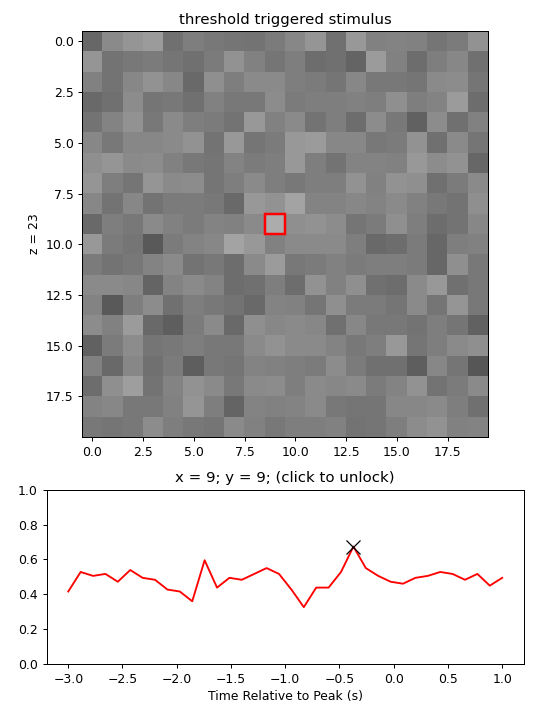

In [6]:
lead_stack_plot = StackExplorer(    
    window_stack,
    zaxis=window_xaxis,
    delta=1,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
lead_stack_plot.stack_ax.set_title("threshold triggered stimulus")
lead_stack_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
lead_stack_plot.fig.tight_layout()

### Rough "receptive field" map via response vs baseline subtraction
Set baseline and response windows in terms of `window_xaxis`.

<IPython.core.display.Javascript object>


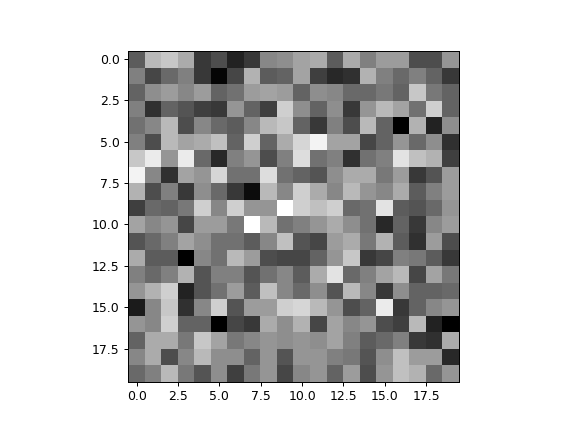

In [7]:
bsln_t0 = -.85
bsln_t1 = -.75
resp_t0 = -.4
resp_t1 = -.3

bsln_mask = (bsln_t0 <= window_xaxis) * (window_xaxis <= bsln_t1)
bsln = np.mean(window_stack[bsln_mask], axis=0)
resp_mask = (resp_t0 <= window_xaxis) * (window_xaxis <= resp_t1)
resp = np.mean(window_stack[resp_mask], axis=0)

sub = resp - bsln
vmin = np.min(sub)
vmax = np.max(sub)

sub_field_fig, sub_field_ax = plt.subplots(1)

sub_field_ax.imshow(sub, vmin=-.2, vmax=.2, cmap="gray",)